Using 11369729 pixels for background fit
Median ~ 3420.00, robust sigma ~ 13.34
Histogram peak at ~ 3421.01
Weighted Gaussian fit:
  mu    = 3418.70
  sigma = 12.44


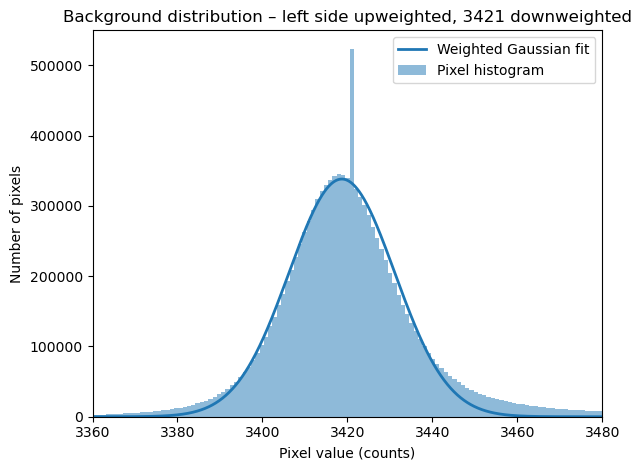

In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Read image and flatten
fname = "mosaic.fits"
with fits.open(fname) as hdul:
    data = hdul[0].data.astype(float)

flat = data.ravel()

# Select background-like pixels around the median
median = np.median(flat)
mad = np.median(np.abs(flat - median))
robust_sigma = 1.4826 * mad

bg_mask = (flat > median - 5 * robust_sigma) & (flat < median + 5 * robust_sigma)
bg_pixels = flat[bg_mask]

print(f"Using {bg_pixels.size} pixels for background fit")
print(f"Median ~ {median:.2f}, robust sigma ~ {robust_sigma:.2f}")

# Histogram of background pixels
bins = 131
hist_counts, bin_edges = np.histogram(bg_pixels, bins=bins)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Peak of the histogram
peak_idx = np.argmax(hist_counts)
peak_center = bin_centers[peak_idx]
print(f"Histogram peak at ~ {peak_center:.2f}")

# Define Gaussian model
def gaussian(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

# Initial guesses
A0 = hist_counts.max()
mu0 = peak_center
sigma0 = robust_sigma
p0 = [A0, mu0, sigma0]

fit_mask = hist_counts > 0
x_fit = bin_centers[fit_mask]
y_fit = hist_counts[fit_mask]

# Base sigmas for curve_fit
sigma_fit = np.ones_like(y_fit, dtype=float)

# Zero weight for the 3421 bin
bin_width = bin_edges[1] - bin_edges[0]
missing_center = 3421.0

# Find which fit bin is centred on 3421
idx_missing = np.argmin(np.abs(x_fit - missing_center))
if np.abs(x_fit[idx_missing] - missing_center) < bin_width:
    sigma_fit[idx_missing] = 1e9   # zero weight

# Higher weight on the left side of the peak, lower on the right
left_mask  = x_fit < mu0
right_mask = x_fit >= mu0

# Example weights: left side 2x weight, right side 0.5 weight
# Weight ∝ 1/sigma^2
sigma_fit[left_mask]  *= 0.7   # smaller sigma for higher weight
sigma_fit[right_mask] *= 1.4   # larger sigma  for lower weight

# Weighted Gaussian fit
popt, pcov = curve_fit(
    gaussian,
    x_fit,
    y_fit,
    p0=p0,
    sigma=sigma_fit,
    absolute_sigma=True,
    maxfev=10000
)

A_fit, mu_fit, sigma_fit_val = popt
print("Weighted Gaussian fit:")
print(f"  mu    = {mu_fit:.2f}")
print(f"  sigma = {sigma_fit_val:.2f}")

#Plot
plt.figure()

plt.bar(bin_centers, hist_counts,
        width=bin_edges[1] - bin_edges[0],
        alpha=0.5, label="Pixel histogram")
plt.xlim(3360, 3480)
plt.ylim(0, hist_counts.max()*1.05)

x_model = np.linspace(bin_centers.min(), bin_centers.max(), 1000)
y_model = gaussian(x_model, *popt)
plt.plot(x_model, y_model, linewidth=2, label="Weighted Gaussian fit")

plt.xlabel("Pixel value (counts)")
plt.ylabel("Number of pixels")
plt.title("Background distribution – left side upweighted, 3421 downweighted")
plt.legend()
plt.tight_layout()
plt.show()


In [1]:
import numpy as np
from astropy.io import fits
from scipy import ndimage as ndi

# background
def bg_sigma(image, bad_value=3421.0):
    flat = image.ravel()
    flat = flat[np.isfinite(flat) & (flat != bad_value)]
    med = float(np.median(flat))
    mad = float(np.median(np.abs(flat - med)))
    sig = float(1.4826 * mad) if mad > 0 else float(np.std(flat))
    return med, sig

# spike masking around a saturated star peak
def mask_star_spikes_8dir(image, y0, x0, level, half_width=2, gap_tol=12):
    ny, nx = image.shape
    out = np.zeros((ny, nx), dtype=bool)

    directions = [
        ( 1,  0), (-1,  0),
        ( 0,  1), ( 0, -1),
        ( 1,  1), (-1, -1),
        ( 1, -1), (-1,  1),
    ]

    for dy, dx in directions:
        pdy, pdx = -dx, dy
        y, x = y0, x0
        gaps = 0
        while 0 <= y < ny and 0 <= x < nx and gaps < gap_tol:
            if image[y, x] >= level:
                gaps = 0
                for k in range(-half_width, half_width + 1):
                    yy = y + k * pdy
                    xx = x + k * pdx
                    if 0 <= yy < ny and 0 <= xx < nx:
                        out[yy, xx] = True
            else:
                gaps += 1
            y += dy
            x += dx

    return out

# helpers for circle radius that stops varying
def _add_disk(mask, y0, x0, R):
    """Add a filled circle to mask using a tight bounding box."""
    ny, nx = mask.shape
    R = float(R)
    r = int(np.ceil(R))
    y1 = max(0, y0 - r); y2 = min(ny - 1, y0 + r)
    x1 = max(0, x0 - r); x2 = min(nx - 1, x0 + r)

    yy, xx = np.ogrid[y1:y2+1, x1:x2+1]
    disk = (yy - y0)**2 + (xx - x0)**2 <= R*R
    mask[y1:y2+1, x1:x2+1] |= disk

def circle_radius_until_plateau(
    image, y0, x0,
    bg, sig,
    bad_value=3421.0,
    r_start=3,
    r_max=600,
    dr=2,
    min_ring_pix=200,
    plateau_window=8,
    tol_sigma=0.25,
    bg_k=2.0,
):
    """
    Grow radius in steps until the annulus median stops changing evidently.
    We detect a plateau when:
      - std(last plateau_window ring-median values) < tol
      - abs(mean(last window) - mean(previous window)) < tol
      - and mean(last window) <= bg + bg_k*sigma  (prevents stopping on a bright plateau)
    """
    ny, nx = image.shape
    tol = tol_sigma * sig

    # patch around star for speed
    pad = r_max + dr + 2
    y1 = max(0, y0 - pad); y2 = min(ny - 1, y0 + pad)
    x1 = max(0, x0 - pad); x2 = min(nx - 1, x0 + pad)

    patch = image[y1:y2+1, x1:x2+1]
    valid = np.isfinite(patch) & (patch != bad_value)

    yy, xx = np.ogrid[y1:y2+1, x1:x2+1]
    rr2 = (yy - y0)**2 + (xx - x0)**2

    meds = []
    radii = []

    r = int(r_start)
    while r < r_max:
        rin2 = r*r
        rout = r + dr
        rout2 = rout*rout

        ring = (rr2 >= rin2) & (rr2 < rout2) & valid
        vals = patch[ring]
        if vals.size >= min_ring_pix:
            med = float(np.median(vals))
            meds.append(med)
            radii.append(rout)

            if len(meds) >= 2 * plateau_window:
                prev = np.array(meds[-2*plateau_window:-plateau_window], float)
                last = np.array(meds[-plateau_window:], float)

                prev_mean = float(np.mean(prev))
                last_mean = float(np.mean(last))
                last_std  = float(np.std(last))

                if (last_std < tol) and (abs(last_mean - prev_mean) < tol) and (last_mean <= bg + bg_k*sig):
                    return float(rout), {
                        "tol": float(tol),
                        "last_mean": last_mean,
                        "last_std": last_std,
                        "bg_target": float(bg + bg_k*sig),
                        "rings_used": len(meds)
                    }

        r += dr

    return float(r_max), {
        "tol": float(tol),
        "last_mean": float(meds[-1]) if meds else np.nan,
        "last_std": np.nan,
        "bg_target": float(bg + bg_k*sig),
        "rings_used": len(meds),
        "note": "hit r_max"
    }

# main cleaning using bwlabel-style labeling
def remove_saturation_artifacts(
    image,
    bad_value=3421.0,
    detect_sigma=5.0,
    spike_sigma=10.0,
    spike_half_width=2,
    spike_gap_tol=12,
    dilate_iters=2,
    fill_value="bg",
    sat_level=36000.0,

    # per-saturated-core circle growth
    circle_r_max=600,
    circle_dr=2,
    circle_plateau_window=8,
    circle_tol_sigma=0.25,
    circle_bg_k=2.0,
    circle_margin=3.0
):
    img = image.astype(float).copy()

    bg, sig = bg_sigma(img, bad_value=bad_value)

    # Make binary map of bright pixels
    thresh = bg + detect_sigma * sig
    bright = (img >= thresh) & np.isfinite(img) & (img != bad_value)

    # Label connected components
    structure = np.ones((3, 3), dtype=int)  # 8-connected
    labels, nlab = ndi.label(bright, structure=structure)

    print(f"[bg] {bg:.2f}, [sigma] {sig:.2f}, detect thresh={thresh:.2f}")
    print(f"[label] found {nlab} connected bright objects")
    print(f"[sat] sat_level fixed = {sat_level:.2f}")

    # Find which labeled objects are saturated
    saturated_ids = []
    for lab_id in range(1, nlab + 1):
        obj = (labels == lab_id)
        if not np.any(obj):
            continue
        if float(np.max(img[obj])) >= sat_level:
            saturated_ids.append(lab_id)

    print(f"[sat] saturated objects: {len(saturated_ids)}")

    # Build mask for saturated cores
    sat_mask = np.isin(labels, saturated_ids)

    # dilate saturated cores so we definitely cover the blob
    if dilate_iters and dilate_iters > 0:
        sat_mask = ndi.binary_dilation(sat_mask, iterations=dilate_iters)

    # add a circle mask per saturated object, radius grown until plateau
    radii_list = []
    for lab_id in saturated_ids:
        obj = (labels == lab_id)

        # peak coordinate inside this object
        idx = np.argmax(img * obj)  # zeros outside
        y0, x0 = np.unravel_index(int(idx), img.shape)

        R, infoR = circle_radius_until_plateau(
            img, int(y0), int(x0),
            bg=bg, sig=sig,
            bad_value=bad_value,
            r_start=3,
            r_max=circle_r_max,
            dr=circle_dr,
            plateau_window=circle_plateau_window,
            tol_sigma=circle_tol_sigma,
            bg_k=circle_bg_k
        )
        R = float(R + circle_margin)
        radii_list.append((int(lab_id), int(y0), int(x0), float(R), infoR.get("rings_used", 0)))

        _add_disk(sat_mask, int(y0), int(x0), R)

    # Spikes from each saturated object
    spike_level = bg + spike_sigma * sig
    spike_mask = np.zeros_like(sat_mask)

    for lab_id in saturated_ids:
        obj = (labels == lab_id)
        idx = np.argmax(img * obj)
        y0, x0 = np.unravel_index(int(idx), img.shape)

        spike_mask |= mask_star_spikes_8dir(
            img, int(y0), int(x0),
            level=spike_level,
            half_width=spike_half_width,
            gap_tol=spike_gap_tol
        )

    total_mask = sat_mask | spike_mask

    # Replace masked pixels with background or 0
    replacement = bg if fill_value == "bg" else float(fill_value)
    cleaned = img.copy()
    cleaned[total_mask] = replacement

    info = {
        "bg": bg,
        "sigma": sig,
        "detect_thresh": float(thresh),
        "sat_level": float(sat_level),
        "spike_level": float(spike_level),
        "n_labels": int(nlab),
        "n_saturated": int(len(saturated_ids)),
        "circle_params": {
            "r_max": int(circle_r_max),
            "dr": int(circle_dr),
            "plateau_window": int(circle_plateau_window),
            "tol_sigma": float(circle_tol_sigma),
            "bg_k": float(circle_bg_k),
            "margin": float(circle_margin),
        },
        # list of (label_id, y0, x0, R, rings_used)
        "circle_radii": radii_list[:50],
        "circle_radii_count": len(radii_list),
    }

    return cleaned, labels, total_mask, info


if __name__ == "__main__":
    with fits.open("mosaic.fits") as hdul:
        img = hdul[0].data.astype(float)

    cleaned, labels, sat_and_spike_mask, info = remove_saturation_artifacts(
        img,
        bad_value=3421.0,
        detect_sigma=5.0,
        spike_sigma=10.0,
        spike_half_width=2,
        spike_gap_tol=12,
        dilate_iters=3,
        fill_value="bg",
        sat_level=36000.0,

        # circle growth tuning
        circle_r_max=700,
        circle_dr=2,
        circle_plateau_window=8,
        circle_tol_sigma=0.25,
        circle_bg_k=2.0,
        circle_margin=5.0
    )

    print(info)


    fits.writeto("mosaic_cleaned_enhanced.fits", cleaned, overwrite=True)


[bg] 3419.00, [sigma] 14.83, detect thresh=3493.13
[label] found 9882 connected bright objects
[sat] sat_level fixed = 36000.00
[sat] saturated objects: 24
{'bg': 3419.0, 'sigma': 14.825999999999999, 'detect_thresh': 3493.13, 'sat_level': 36000.0, 'spike_level': 3567.26, 'n_labels': 9882, 'n_saturated': 24, 'circle_params': {'r_max': 700, 'dr': 2, 'plateau_window': 8, 'tol_sigma': 0.25, 'bg_k': 2.0, 'margin': 5.0}, 'circle_radii': [(27, 2, 997, 74.0, 19), (190, 30, 1692, 70.0, 24), (242, 125, 1433, 76.0, 27), (1152, 578, 1772, 68.0, 23), (1218, 662, 65, 116.0, 47), (1316, 657, 2530, 54.0, 16), (2190, 1115, 2522, 74.0, 26), (2740, 1424, 2089, 96.0, 37), (3034, 1495, 634, 76.0, 27), (3511, 1654, 966, 60.0, 19), (4038, 1938, 675, 66.0, 22), (4481, 2261, 904, 114.0, 46), (4512, 2263, 704, 62.0, 20), (4570, 2300, 446, 76.0, 27), (5215, 2752, 973, 102.0, 40), (6664, 3296, 775, 110.0, 44), (7686, 3443, 2562, 66.0, 16), (7900, 3600, 2535, 54.0, 16), (8013, 3758, 2135, 94.0, 36), (8208, 3923, 1